In [15]:
import torch
import open_clip
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import pandas as pd

# === Конфиги ===
CSV_PATH = 'merged_dataset_v2.csv'
BATCH_SIZE = 128
NUM_WORKERS = 0
NUM_EPOCHS = 30
LR = 1e-6
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MODEL_NAME = 'ViT-B-32'
PRETRAINED = 'laion2b_s34b_b79k'

WEIGHT_DECAY = 1e-2
SPLITS = ['train', 'val', 'test', 'обучение', 'валидация', 'тест']


 # можно адаптировать под свой CSV
df = pd.read_csv(CSV_PATH)
all_classes = sorted(df['class_name'].unique().tolist())

tokenizer = open_clip.get_tokenizer(MODEL_NAME)
prompts = [f"{c}" for c in all_classes]
text_tokens = tokenizer(prompts).to(DEVICE)


In [5]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
mean=[0.48145466, 0.4578275, 0.40821073]
std=[0.26862954, 0.26130258, 0.27577711]


# Для валидации/теста (только resize + norm)
val_transform = A.Compose([
    A.Resize(224, 224),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])

class CsvImageDataset(Dataset):
    def __init__(self, csv_path, split, transform=None, class_names=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if class_names is None:
            self.class_names = sorted(self.df['class_name'].unique())
        else:
            self.class_names = class_names

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['image_path']).convert('RGB'))
        if self.transform:
            image = self.transform(image)['image']
        label = self.class_to_idx[row['class_name']]
        return image, label

In [17]:
import torch
from tqdm import tqdm


DATASET_DIRS = [
    'CUB_200_2011_split',
    'dtd_split',
    'fungi_clef_2022_split'
]


PROMPT_TEMPLATES_BY_DOMAIN = {
    'fungi_clef_2022_split': [
        'a photo of a {} mushroom',
        'a close-up of {} fungus',
        'a macro image of {} in the forest',
        'a detailed picture of {} mushroom',
        'an image of {} fungus in nature'
    ],
    'dtd_split': [
        'a photo of a {} texture',
        'a close-up of a {} pattern',
        'an image showing {} texture',
        'a detailed photo of a {} surface',
        'an abstract image with {}'
    ],
    'CUB_200_2011_split': [
        'a photo of a {} bird',
        'a close-up of {}',
        'an image of {} in the wild',
        'a detailed picture of {}',
        'a photo of {} perched on a branch'
    ],
    # fallback/общие шаблоны
    'default': [
        'a photo of a {}',
        'an image of {}',
        'a detailed photo of {}',
        'a close-up of {}'
    ]
}


def get_prompt_templates_for_domain(domain):
    domain = domain.lower()
    for key in PROMPT_TEMPLATES_BY_DOMAIN:
        if key in domain:
            return PROMPT_TEMPLATES_BY_DOMAIN[key]
    return PROMPT_TEMPLATES_BY_DOMAIN['default']

def get_prompt_ensemble_text_features(class_names, model, tokenizer, device, prompt_templates):
    all_text_features = []
    for class_name in class_names:
        prompts = [template.format(class_name) for template in prompt_templates]
        text_tokens = tokenizer(prompts).to(device)
        with torch.no_grad():
            text_features = model.encode_text(text_tokens)
            mean_feature = text_features.mean(dim=0, keepdim=True)
            mean_feature = mean_feature / mean_feature.norm(dim=-1, keepdim=True)
        all_text_features.append(mean_feature)
    return torch.cat(all_text_features, dim=0)

# --- Пример запуска под каждый домен ---

model, _, preprocess = open_clip.create_model_and_transforms(
    MODEL_NAME, pretrained=PRETRAINED
)
model = model.to(DEVICE)
tokenizer = open_clip.get_tokenizer(MODEL_NAME)



for domain in DATASET_DIRS:  # DATASET_DIRS = ['fungi', 'dtd', 'cub'] или твои домены
    # Фильтруем датасет
    domain_df = df[(df['split'] == 'test') & (df['domain'] == domain)].reset_index(drop=True)
    if len(domain_df) == 0:
        continue
    domain_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
    domain_dataset.df = domain_df
    domain_dataset.class_names = sorted(domain_dataset.df['class_name'].unique())
    domain_dataset.class_to_idx = {cls: i for i, cls in enumerate(domain_dataset.class_names)}
    domain_loader = DataLoader(domain_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    class_names = domain_dataset.class_names

    # Шаблоны под домен
    prompt_templates = get_prompt_templates_for_domain(domain)

    ensemble_text_features = get_prompt_ensemble_text_features(
        class_names, model, tokenizer, DEVICE, prompt_templates
    )

    # Инференс
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(domain_loader, desc=f'Prompt Ensemble Inference ({domain})'):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            logits = image_features @ ensemble_text_features.T
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'DOMAIN={domain} | PromptEnsembling: Accuracy={acc:.4f}  Macro-F1={f1:.4f}')

Prompt Ensemble Inference (CUB_200_2011_split): 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]


DOMAIN=CUB_200_2011_split | PromptEnsembling: Accuracy=0.7463  Macro-F1=0.7304


Prompt Ensemble Inference (dtd_split): 100%|██████████| 17/17 [00:14<00:00,  1.16it/s]


DOMAIN=dtd_split | PromptEnsembling: Accuracy=0.6824  Macro-F1=0.6691


Prompt Ensemble Inference (fungi_clef_2022_split): 100%|██████████| 20/20 [00:05<00:00,  3.63it/s]

DOMAIN=fungi_clef_2022_split | PromptEnsembling: Accuracy=0.1381  Macro-F1=0.1080


In [10]:
import albumentations as A
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

mean=[0.48145466, 0.4578275, 0.40821073]
std=[0.26862954, 0.26130258, 0.27577711]

In [11]:
def build_prompts(class_name):
    fungi_keywords = [
        "Russula", "Agaricus", "Paxillus", "Flammulaster",
        "Mycetinis", "Hygrophoropsis", "Chroogomphus", "Lepista", "granulosus", "aurantiaca",
        "lichen", "Tephromela"
    ]
    bird_keywords = [
        "Grebe", "Auklet", "Oriole", "Warbler", "Tern", "Vireo", "Redstart", "Gull",
        "Merganser", "Widow", "Blue_Warbler", "Horned", "California"
    ]

    texture_keywords = [
        "freckled", "chequered", "braided"
    ]
    class_l = str(class_name).lower()
    if any(k.lower() in class_l for k in fungi_keywords):
        return [
            f"a photo of {class_name} mushroom",
            f"a macro photo of {class_name} fungus in a forest",
            f"the mushroom species {class_name}",
            f"an image of {class_name} fungus growing on wood"
        ]
    elif any(k.lower() in class_l for k in bird_keywords):
        return [
            f"a photo of a {class_name} bird",
            f"an image of a {class_name} perched on a branch",
            f"a close-up photo of the {class_name}",
            f"the bird species {class_name}",
            f"a {class_name} bird in its natural habitat"
        ]
    elif any(k.lower() in class_l for k in texture_keywords):
        return [
            f"a photo of a {class_name} pattern",
            f"an image with {class_name} texture",
            f"a close-up of a {class_name} surface",
            f"a detailed image of {class_name} background"
        ]
    else:
        return [
            f"a photo of {class_name}",
            f"an image of {class_name}",
            f"a close-up of {class_name}"
        ]


In [12]:
PROMPT_TEMPLATES = [
    "a photo of a {}",
    "a photo of the {}",
    "a photo of one {}",
    "a photo of a small {}",
    "an image of a {}",
    "a good photo of a {}",
    "a close-up photo of a {}",
    "a detailed photo of a {}",
    "a blurry photo of a {}",
    "a photo of a {} in the wild",
    "a bright photo of a {}",
    "an artistic rendering of a {}",
]

def get_domain_prompts(class_name, domain):
    if domain == 'CUB_200_2011_split':
        return [
         
        f"a photo of a {class_name} bird",
        f"a close-up photo of a {class_name} bird",
        f"a photo of a {class_name} bird standing on the ground",
        f"a {class_name} bird in the wild",
        f"a {class_name} bird flying in the sky",
    
        f"a high quality photo of a {class_name} bird",
        f"a low quality photo of a {class_name} bird",
        f"a {class_name} bird in a park",
        f"a {class_name} bird in a tree",
        f"a {class_name} bird with other birds",
        f"a {class_name} bird in the forest",
        f"a {class_name} bird under bright sunlight",
        f"a {class_name} bird in the rain",
        f"a {class_name} bird with a long beak",
        f"a {class_name} bird with black and white feathers",
        f"a {class_name} bird with colorful plumage",
        f"a {class_name} bird with spread wings",
        f"a {class_name} bird with folded wings",
        f"a photo of a juvenile {class_name} bird",
        f"a photo of an adult {class_name} bird",
        f"a male {class_name} bird",
        f"a female {class_name} bird",
        f"a photo of a {class_name} chick",
        f"a side view of a {class_name} bird",
        f"a front view of a {class_name} bird",
        f"a {class_name} bird perched on a branch",
        f"a {class_name} bird by the water",
        f"a group of {class_name} birds",
        f"a flock of {class_name} birds flying",
        f"a portrait of a {class_name} bird",
        f"a detailed illustration of a {class_name} bird",
        f"a photo of a {class_name} bird during migration",
        ]
    elif domain == 'dtd_split':
        return [
            f"a close-up photo of {class_name} texture",
            f"a photo of a {class_name} pattern",
            f"a detailed photo of {class_name} surface",
            f"an image of {class_name} texture",
            f"a macro photo of {class_name}",
            f"a {class_name} background",
            f"{class_name} material",
        ]
    elif domain == 'fungi_clef_2022_split':
        return [
        f"a photo of a {class_name} mushroom in a forest",
        f"a close-up photo of the {class_name} mushroom cap and stem",
        f"a group of {class_name} mushrooms growing among moss",
        f"{class_name} mushroom on forest floor",
        f"{class_name} mushroom surrounded by moss and leaves",
        ]
    
    else:
        return [
            f"a photo of a {class_name}",
            f"a picture of a {class_name}",
            f"an example of a {class_name}",
            f"a detailed view of a {class_name}",
        ]
    

val_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2(),
])



from torchvision import transforms

class CsvImageDataset(Dataset):
    def __init__(self, csv_path, split, transform=None, class_names=None):
        df = pd.read_csv(csv_path)
        self.df = df[df['split'] == split].reset_index(drop=True)
        self.transform = transform

        if class_names is None:
            self.class_names = sorted(self.df['class_name'].unique())
        else:
            self.class_names = class_names

        self.class_to_idx = {cls: i for i, cls in enumerate(self.class_names)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image = np.array(Image.open(row['image_path']).convert('RGB'))
        if self.transform:
            image = self.transform(image=image)['image']

            
        label = self.class_to_idx[row['class_name']]
        return image, label
    
# Базовый пайплайн (без аугментаций, только resize/crop)
base_tta = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])


tta_flip = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=1.0),
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])


tta_color = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=1.0),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])


tta_rotate = A.Compose([
    A.Resize(256, 256),
    A.Rotate(limit=25, border_mode=0, value=0, p=1.0), 
    A.CenterCrop(224, 224),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

tta_blur = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.GaussianBlur(blur_limit=(1, 5), p=1.0),
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])



def show_augmented_image(image_np, tta_list, idx=0):
    """
    image_np: np.ndarray (H, W, C), uint8
    tta_list: список albumentations.Compose
    idx: индекс аугментации из списка (например, 0 — базовая, 1 — flip и т.д.)
    """
    tta = tta_list[idx]
    aug = tta(image=image_np)
    img_tensor = aug["image"]  # torch.Tensor (3, H, W)

    # Перевести обратно в (H, W, C) и [0, 1] для визуализации
    img_vis = img_tensor.permute(1, 2, 0).cpu().numpy()  # (H, W, 3)

    # Если после ToTensorV2 значения в [0,1], можно сразу показывать
    # Если после Normalize — верни обратное преобразование!
    if img_vis.max() > 2.0:  # Значит, нормализации не было — просто покажи
        plt.imshow(img_vis)
    else:
        # Пример для CLIP Normalization (разнормализация)
        mean = np.array([0.48145466, 0.4578275, 0.40821073])
        std = np.array([0.26862954, 0.26130258, 0.27577711])
        img_vis = img_vis * std + mean
        img_vis = np.clip(img_vis, 0, 1)
        plt.imshow(img_vis)

    plt.axis("off")
    plt.title(f"TTA {idx}")
    plt.show()
    
def get_tta_image_embedding(image_np, model, device, tta_list, aggregation="mean"):
    embs = []
    for tta in tta_list:
        aug = tta(image=image_np)
        img_tensor = aug["image"]
        #print("img_tensor (before float):", img_tensor.shape, img_tensor.dtype, img_tensor.min().item(), img_tensor.max().item())
        img_tensor = img_tensor.float().unsqueeze(0).to(device)
        #print("img_tensor (to model):", img_tensor.shape, img_tensor.dtype, img_tensor.min().item(), img_tensor.max().item())
        emb = model.encode_image(img_tensor)
        emb = torch.nn.functional.normalize(emb, dim=1)
        embs.append(emb)
    embs = torch.cat(embs, dim=0)  # (n_aug, dim)
    emb_final = embs.mean(dim=0, keepdim=True)
    #print("emb_final norm:", emb_final.norm(dim=1).item())
    emb_final = torch.nn.functional.normalize(emb_final, dim=1)


    if aggregation == "mean":
        emb_final = emb_final.mean(dim=0, keepdim=True)
    elif aggregation == "max":
        emb_final = emb_final.max(dim=0, keepdim=True).values
    elif aggregation == "median":
        emb_final = emb_final.median(dim=0, keepdim=True).values
    else:
        raise ValueError(f"Unknown aggregation method: {aggregation}")
    #print("emb_final norm (after norm):", emb_final.norm(dim=1).item())
    return emb_final


@torch.no_grad()
def get_prompt_ensemble_text_features(
    class_names, model, tokenizer, domain, device="cuda", batch_size=8,aggregation="median",
):
    """
    Для каждого класса создает набор промптов (шаблонов), кодирует их батчами,
    усредняет эмбеддинги, возвращает тензор (num_classes, dim).
    """
    model.eval()
    all_class_embeds = []

    for cname in class_names:
        templates = get_domain_prompts(cname, domain)  # Получаем шаблоны под домен
        prompts = templates  # Шаблоны уже возвращают готовые промпты с подставленным именем

        batch_embeds = []

        # Батчим промпты по batch_size
        for i in range(0, len(prompts), batch_size):
            batch_prompts = prompts[i:i+batch_size]
            tokens = tokenizer(batch_prompts).to(device)
            text_features = model.encode_text(tokens)
            text_features = torch.nn.functional.normalize(text_features, dim=1)
            batch_embeds.append(text_features.cpu())

        # Собираем все эмбеддинги промптов для этого класса
        class_prompts_embeds = torch.cat(batch_embeds, dim=0)  # (n_prompts, dim)
        # Агрегируем: можно брать mean, max, median и др.

        if aggregation == "mean":
            class_embed = class_prompts_embeds.mean(dim=0, keepdim=True)
        elif aggregation == "max":
            class_embed = class_prompts_embeds.max(dim=0, keepdim=True).values
        elif aggregation == "median":
            class_embed = class_prompts_embeds.median(dim=0, keepdim=True).values
        else:
            raise ValueError(f"Unknown aggregation method: {aggregation}")

        class_embed = torch.nn.functional.normalize(class_embed, dim=1)
        all_class_embeds.append(class_embed)

    all_class_embeds = torch.cat(all_class_embeds, dim=0)  # (num_classes, dim)
    return all_class_embeds.to(device)

C:\Users\Admin\AppData\Local\Temp\ipykernel_22724\481870177.py:148: UserWarning: Argument(s) 'value' are not valid for transform Rotate
  A.Rotate(limit=25, border_mode=0, value=0, p=1.0),


In [22]:
val_transform(image=np.array(df['image_path'][0]))



error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = <U94 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


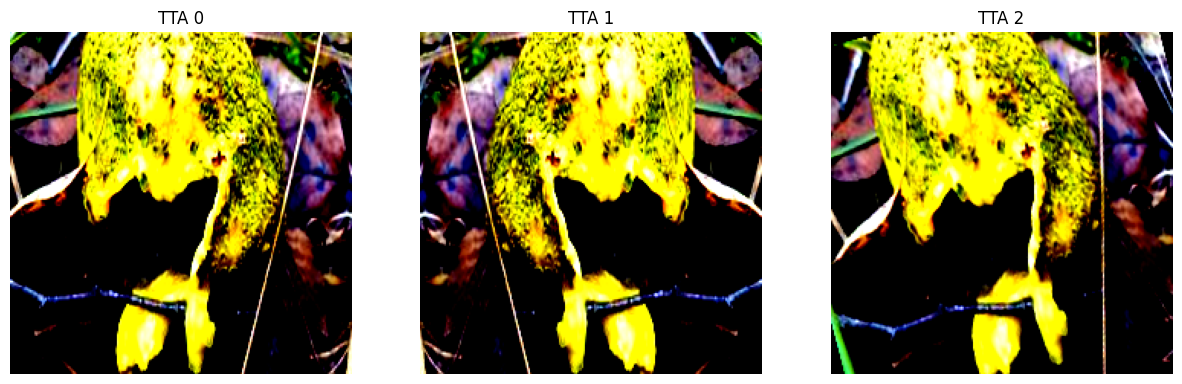

In [320]:
show_augmented_image

In [18]:
for domain in DATASET_DIRS:  # ['fungi', 'dtd', 'cub'] или твои домены
    # Фильтруем датасет
    domain_df = df[(df['split'] == 'test') & (df['domain'] == domain)].reset_index(drop=True)
    if len(domain_df) == 0:
        continue
    domain_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
    domain_dataset.df = domain_df
    domain_dataset.class_names = sorted(domain_dataset.df['class_name'].unique())
    domain_dataset.class_to_idx = {cls: i for i, cls in enumerate(domain_dataset.class_names)}
    domain_loader = DataLoader(domain_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    class_names = domain_dataset.class_names

    # --- Prompt Ensemble ---
    ensemble_text_features = get_prompt_ensemble_text_features(
        class_names, model, tokenizer,domain, DEVICE
    )

    # Инференс
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(domain_loader, desc=f'Prompt Ensemble Inference ({domain})'):
            images = images.to(DEVICE)
            image_features = model.encode_image(images)
            image_features = torch.nn.functional.normalize(image_features, dim=1)
            logits = image_features @ ensemble_text_features.T
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'DOMAIN={domain} | PromptEnsembling: Accuracy={acc:.4f}  Macro-F1={f1:.4f}')

RuntimeError: Invalid device string: 'CUB_200_2011_split'

In [13]:
from tqdm import tqdm


tta_list = [base_tta, tta_flip, tta_rotate]

#tta_list = [base_tta]

DATASET_DIRS = [
    'CUB_200_2011_split',
    'dtd_split',
    'fungi_clef_2022_split'
]


for domain in DATASET_DIRS:
    domain_df = df[(df['split'] == 'test') & (df['domain'] == domain)].reset_index(drop=True)
    if len(domain_df) == 0:
        continue
    domain_dataset = CsvImageDataset(CSV_PATH, split='test', transform=None)  # transform=None!
    domain_dataset.df = domain_df
    domain_dataset.class_names = sorted(domain_dataset.df['class_name'].unique())
    domain_dataset.class_to_idx = {cls: i for i, cls in enumerate(domain_dataset.class_names)}
    domain_loader = DataLoader(domain_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS)
    class_names = domain_dataset.class_names

    # --- Prompt Ensemble ---
    ensemble_text_features = get_prompt_ensemble_text_features(
        class_names, model, tokenizer, domain, DEVICE
    )

    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(domain_loader, desc=f'Prompt Ensemble Inference ({domain})'):
            images, labels = batch  # images: (1, C, H, W) or np.ndarray
            image_np = images[0]
            if not isinstance(image_np, np.ndarray):
                image_np = image_np.cpu().numpy()
                
            tta_emb = get_tta_image_embedding(image_np, model, DEVICE, tta_list, aggregation="mean")  # (1, dim)
            logits = tta_emb @ ensemble_text_features.T
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    print(f'DOMAIN={domain} | PromptEnsembling+TTA: Accuracy={acc:.4f}  Macro-F1={f1:.4f}')

NameError: name 'df' is not defined

In [ ]:
DOMAIN=fungi_clef_2022_split | PromptEnsembling+TTA: Accuracy=0.1959  Macro-F1=0.1182

In [300]:
DOMAIN=fungi_clef_2022_split | PromptEnsembling+TTA: Accuracy=0.1873  Macro-F1=0.1121

SyntaxError: invalid syntax (635744937.py, line 1)

In [ ]:
DOMAIN=fungi_clef_2022_split | PromptEnsembling+TTA: Accuracy=0.1896  Macro-F1=0.1151

In [ ]:
DOMAIN=fungi_clef_2022_split | PromptEnsembling+TTA: Accuracy=0.1916  Macro-F1=0.1191

In [315]:
df[(df['split'] == 'test') & (df['domain'] == 'CUB_200_2011_split')].reset_index(drop=True)
df['class_name'] = df['class_name'].str.replace(r"^\d+\.\s*", "", regex=True).str.replace("_", " ")

In [142]:
df['class_name']

0             California Gull
1              Crested Auklet
2                  Least Tern
3           American Redstart
4          Paxillus involutus
                 ...         
56897        Cyathus striatus
56898      Bjerkandera fumosa
56899    Scleroderma citrinum
56900        Green Kingfisher
56901               sprinkled
Name: class_name, Length: 56902, dtype: object

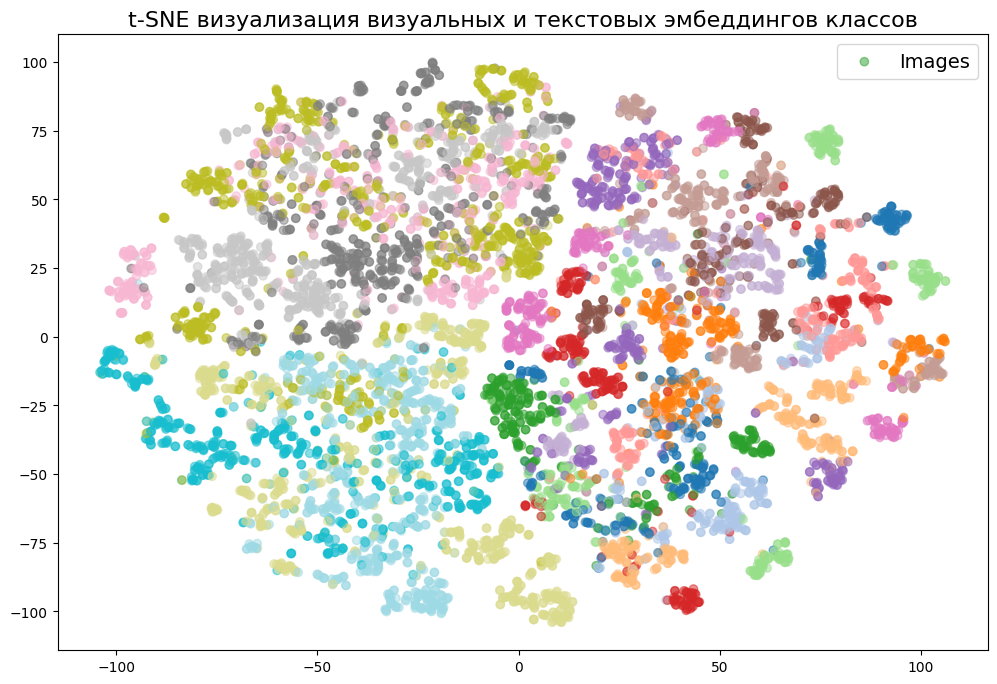

In [39]:
import torch
import numpy as np

test_dataset = CsvImageDataset(CSV_PATH, split='test', transform=val_transform)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

image_embeds = []
labels = []
for images, lbls in test_loader:
    images = images.to(DEVICE)
    with torch.no_grad():
        feats = model.encode_image(images).cpu().numpy()
    image_embeds.append(feats)
    labels.extend(lbls.numpy())
image_embeds = np.concatenate(image_embeds, axis=0)  # shape: [num_images, D]
labels = np.array(labels)

# Текстовые эмбеддинги
text_embeds = ensemble_text_features.cpu().numpy()  # shape: [num_classes, D]




from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Для быстрого просмотра лучше сначала понизить размерность до 50 через PCA, потом t-SNE
pca = PCA(n_components=50)
image_embeds_pca = pca.fit_transform(image_embeds)
text_embeds_pca = pca.transform(text_embeds)

tsne = TSNE(n_components=2, random_state=42, perplexity=min(5, len(text_embeds_pca)-1))
image_embeds_2d = tsne.fit_transform(image_embeds_pca)
text_embeds_2d = tsne.fit_transform(text_embeds_pca)





C:\Users\Admin\AppData\Local\Temp\ipykernel_20036\2209479207.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=14)


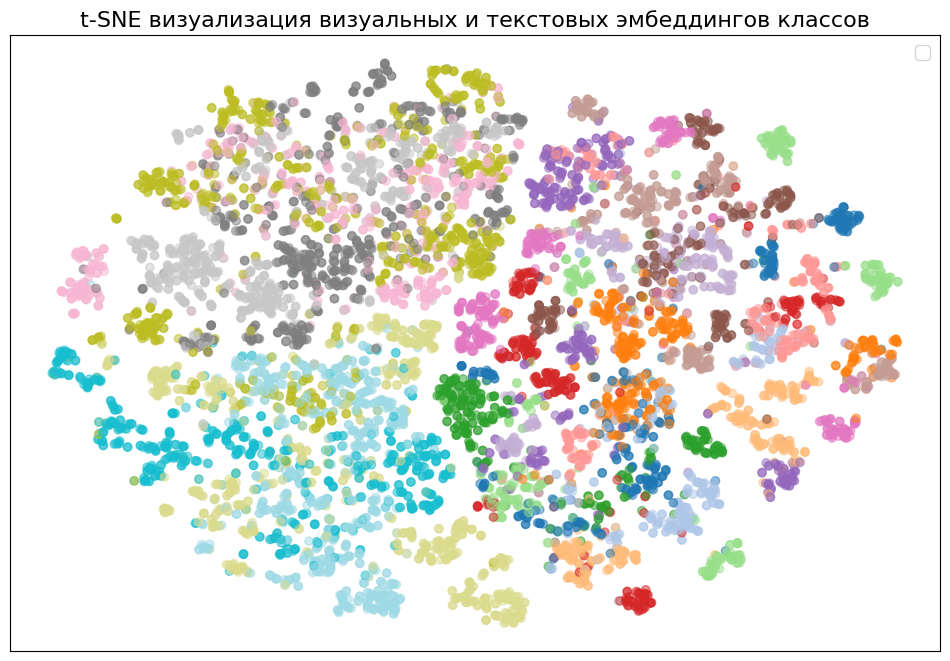

In [66]:

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

# Покажем изображения точками (цвет по классу)
plt.scatter(image_embeds_2d[:, 0], image_embeds_2d[:, 1], 
            c=labels, cmap='tab20', alpha=0.5)
plt.xticks([])
plt.yticks([])
# Покажем текстовые эмбеддинги крупными крестиками
# plt.scatter(text_embeds_2d[:, 0], text_embeds_2d[:, 1], 
#             c=np.arange(len(text_embeds_2d)), cmap='tab20', 
#             marker='x', s=200, linewidths=3, label='Text prompts')

plt.legend(fontsize=14)
plt.title("t-SNE визуализация визуальных и текстовых эмбеддингов классов", fontsize=16)
plt.show()

In [29]:
print("Максимальный индекс:", max(idxs), "Размер text_embeds_2d:", text_embeds_2d.shape[0])

Максимальный индекс: 199 Размер text_embeds_2d: 20


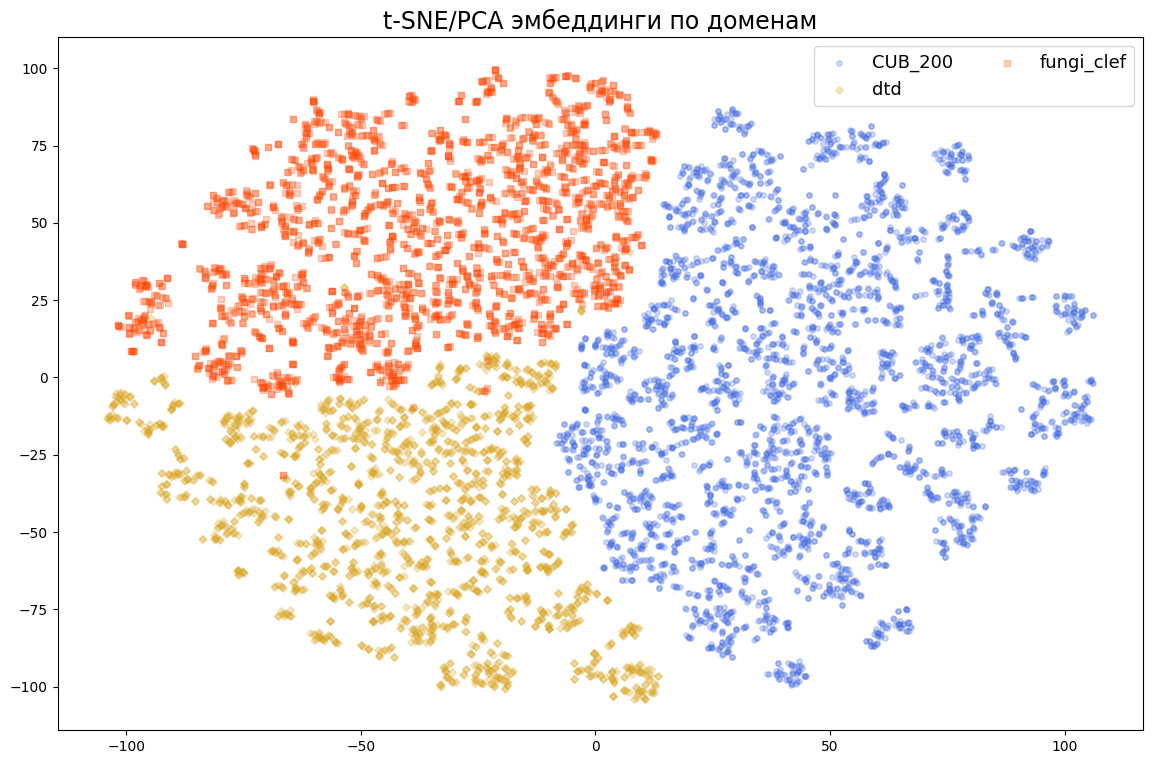

In [ ]:
test_df = df[df['split'] == 'test'].reset_index(drop=True)
image_domains = test_df['domain'].tolist()  # домен для каждой картинки из теста
labels = test_df['class_name'].tolist()     # список названий классов для этих картинок

# Для текстовых эмбеддингов классов (крестиков)
# Присваиваем домен как наиболее часто встречающийся у этого класса
class_to_domain = df.groupby('class_name')['domain'].agg(lambda x: x.value_counts().idxmax()).to_dict()
class_names = list(class_to_domain.keys())
text_domains = [class_to_domain[cls] for cls in class_names]



domain_color_map = {
    "CUB_200_2011_split": "royalblue",
    "fungi_clef_2022_split": "orangered",
    "dtd_split": "goldenrod"
}
domain_marker_map = {
    "CUB_200_2011_split": "o",
    "fungi_clef_2022_split": "s",
    "dtd_split": "D"
}



IndexError: index 20 is out of bounds for axis 0 with size 20

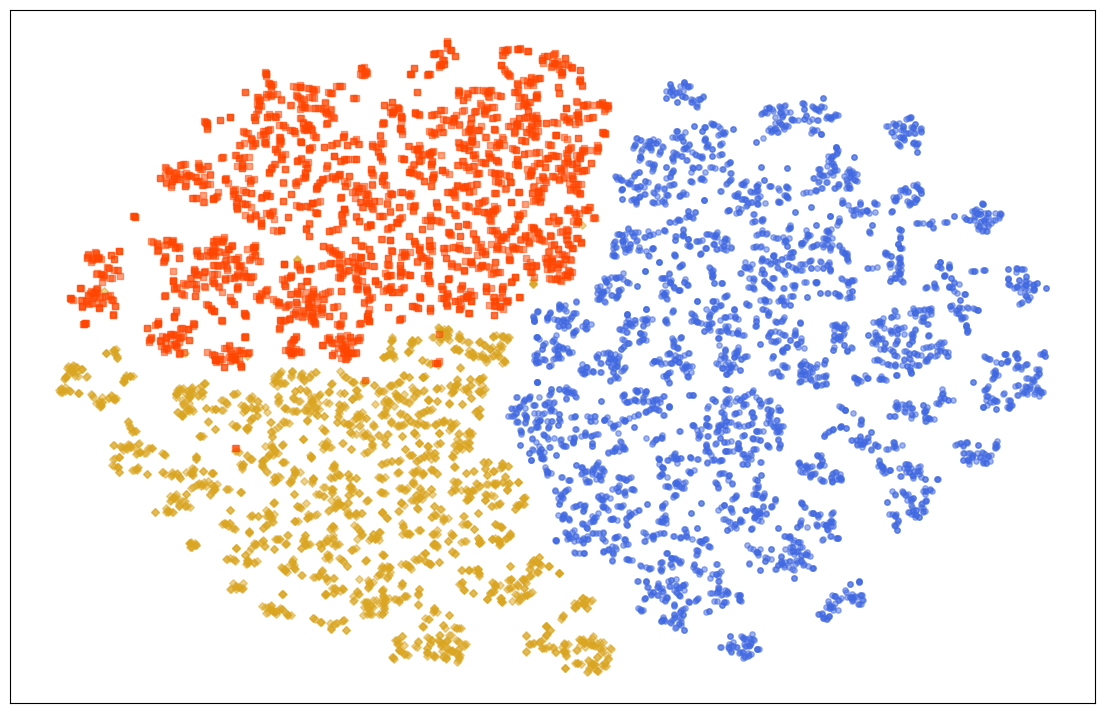

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 9))
unique_domains = set(image_domains)
plt.xticks([])
plt.yticks([])
# Для изображений
for domain in unique_domains:
    mask = [d == domain for d in image_domains]
    plt.scatter(
        np.array(image_embeds_2d)[mask, 0],
        np.array(image_embeds_2d)[mask, 1],
        c=domain_color_map.get(domain, "gray"),
        label=f"{domain.rsplit('_', 2)[0]}",
        alpha=0.5,
        marker=domain_marker_map.get(domain, "x"),
        s=15
    )

# Для текстовых эмбеддингов классов (крестики)
unique_text_domains = set(text_domains)
for domain in unique_text_domains:
    idxs = [i for i, d in enumerate(text_domains) if d == domain]
    plt.scatter(
        text_embeds_2d[idxs, 0], text_embeds_2d[idxs, 1],
        c=domain_color_map.get(domain, "gray"),
        marker=domain_marker_map.get(domain, "x"),
        edgecolor='black',
        s=180,
        linewidths=2,
        label=f"{domain} class text"
    )

plt.legend(fontsize=13, loc="best", ncol=2)
plt.title("t-SNE/PCA эмбеддинги по доменам", fontsize=17)
plt.show()

In [52]:
len(text_domains)

387

In [53]:
text_embeds_2d.shape[0]

20

In [54]:
text_embeds_all = get_prompt_ensemble_text_features(
    class_names, model, tokenizer, DEVICE
).cpu().numpy()  # shape: [387, D]

# t-SNE/PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Можно сперва PCA, потом t-SNE
pca = PCA(n_components=50)
text_embeds_all_pca = pca.fit_transform(text_embeds_all)
text_embeds_all_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(text_embeds_all_pca)

# Получить домены для всех классов
text_domains_all = [class_to_domain[cls] for cls in class_names]




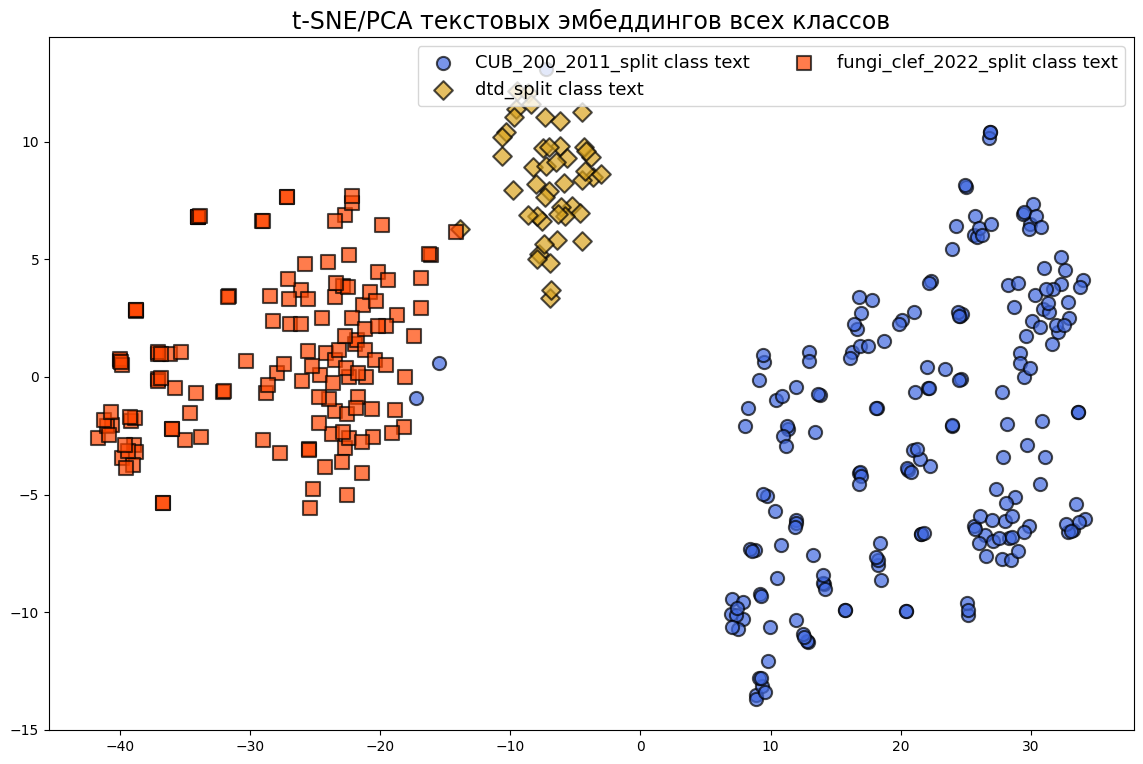

In [55]:
plt.figure(figsize=(14, 9))
for domain in set(text_domains_all):
    idxs = [i for i, d in enumerate(text_domains_all) if d == domain]
    plt.scatter(
        text_embeds_all_2d[idxs, 0], text_embeds_all_2d[idxs, 1],
        c=domain_color_map.get(domain, "gray"),
        marker=domain_marker_map.get(domain, "x"),
        edgecolor='black',
        s=90,
        linewidths=1.5,
        alpha=0.7,
        label=f"{domain} class text"
    )

plt.legend(fontsize=13, loc="best", ncol=2)
plt.title("t-SNE/PCA текстовых эмбеддингов всех классов", fontsize=17)
plt.show()

['Agaricus sylvicola', 'Amanita strobiliformis', 'Aureoboletus gentilis', 'Boletus pinophilus', 'Cetraria islandica', 'Chroogomphus rutilus', 'Coprinopsis romagnesiana', 'Dendrothele acerina', 'Ganoderma lucidum', 'Hygrocybe substrangulata', 'Inocybe stellatospora', 'Laxitextum bicolor', 'Macrolepiota excoriata', 'Mycena clavularis', 'Mycena tenerrima', 'Mycetinis scorodonius', 'Phaeolepiota aurea', 'Russula fellea', 'Scleroderma citrinum', 'Trichoderma strictipile']


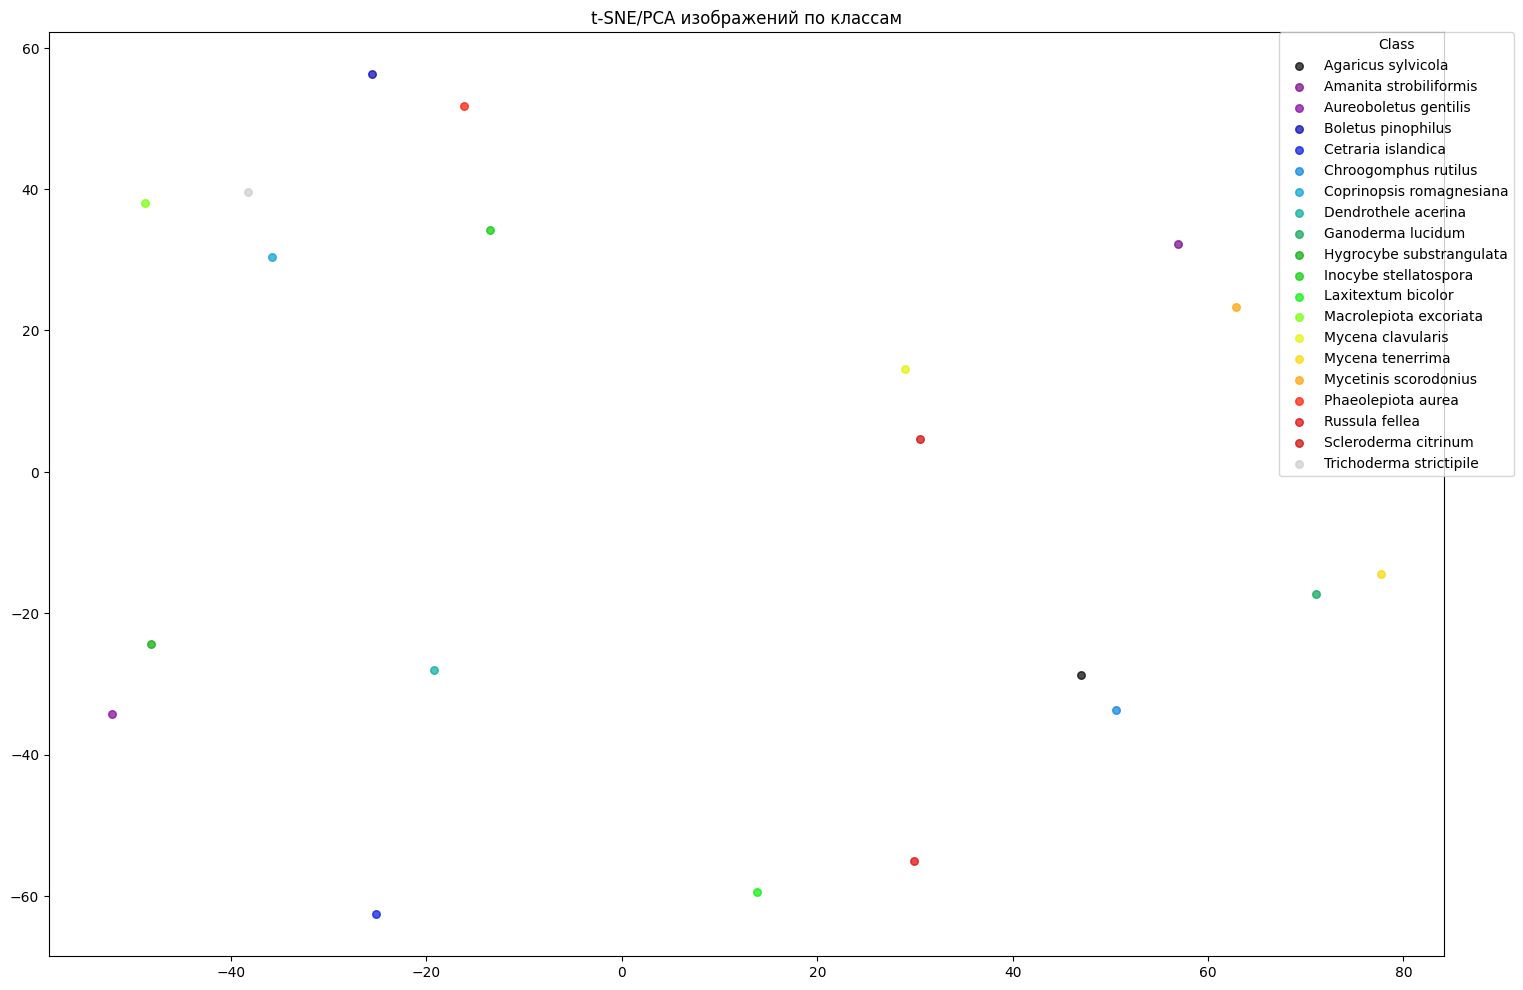

In [309]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

def plot_by_domain(embeds_2d, domains, title, legend_loc="best", markersize=30):
    unique_domains = sorted(set(domains))
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_domains)))
    domain_to_color = {d: c for d, c in zip(unique_domains, colors)}
    domain_to_marker = {d: m for d, m in zip(unique_domains, ['o', 's', 'D', '^', 'v', '<', '>', '*', 'p', 'h'])}

    plt.figure(figsize=(12, 8))
    for domain in unique_domains:
        idxs = [i for i, d in enumerate(domains) if d == domain]
        plt.scatter(
            np.array(embeds_2d)[idxs, 0],
            np.array(embeds_2d)[idxs, 1],
            c=[domain_to_color[domain]],
            marker=domain_to_marker[domain],
            label=domain,
            s=markersize,
            alpha=0.65
        )
    plt.legend(title="Domain", loc=legend_loc)
    plt.title(title)
    plt.show()

def plot_by_class(embeds_2d, class_labels, title, legend_loc="best", markersize=30):
    unique_classes = sorted(set(class_labels))
    print(unique_classes)
    n_classes = len(unique_classes)
    # Для палитры используем большую карту, если классов очень много
    if n_classes <= 20:
        colors = plt.cm.tab20(np.linspace(0, 1, n_classes))
    #elif n_classes <= 256:
    colors = plt.cm.nipy_spectral(np.linspace(0, 1, n_classes))
    # else:
    #     # если >256 классов — повторяем цвета (т.к. matplotlib не умеет больше уникальных)
    #     base_colors = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
    #     colors = np.vstack([base_colors for _ in range((n_classes // 256) + 1)])[:n_classes]
    class_to_color = {c: col for c, col in zip(unique_classes, colors)}
    plt.figure(figsize=(18, 12))
    for class_name in unique_classes:
        idxs = [i for i, c in enumerate(class_labels) if c == class_name]
        plt.scatter(
            np.array(embeds_2d)[idxs, 0],
            np.array(embeds_2d)[idxs, 1],
            c=[class_to_color[class_name]],
            label=class_name,
            s=markersize,
            alpha=0.7
        )
    # Огромную легенду имеет смысл вынести сбоку
    if n_classes <= 30:
        plt.legend(title="Class", loc=legend_loc, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.title(title)
    plt.show()

def visualize_embeddings(image_embeds_2d, image_domains, image_class_labels, 
                        text_embeds_2d, text_domains, text_class_labels,
                        max_classes=20):
    # 1. Все изображения по доменам
    #plot_by_domain(image_embeds_2d, image_domains, "t-SNE/PCA изображений по доменам")
    # 2. Все текстовые эмбеддинги по доменам
    #plot_by_domain(text_embeds_2d, text_domains, "t-SNE/PCA текстов по доменам")
    # 3. Изображения по классам (только топ max_classes, остальные серым)
    plot_by_class(image_embeds_2d, image_class_labels, "t-SNE/PCA изображений по классам")
    # 4. Тексты по классам (только топ max_classes, остальные серым)
    #plot_by_class(text_embeds_2d, text_class_labels, "t-SNE/PCA текстов по классам", max_classes=max_classes)

# === Вызов общей функции ===
# image_embeds_2d — 2D np.array для изображений
# image_domains — список доменов для изображений (тестовых)
# image_class_labels — список названий классов для изображений
# text_embeds_2d — 2D np.array для классов
# text_domains — список доменов для классов
# text_class_labels — список названий классов (в том же порядке, что text_embeds_2d)

visualize_embeddings(
    image_embeds_2d=image_embeds_2d,
    image_domains=image_domains,
    image_class_labels=class_names,
    text_embeds_2d=text_embeds_2d,
    text_domains=text_domains,
    text_class_labels=class_names,
    max_classes=20  # можно больше/меньше, если хочешь более подробную/агрегированную легенду
)

In [166]:
import streamlit as st

def plot_pca_elbow(X, max_components=10000, threshold=0.95):
    pca = PCA(n_components=min(max_components, X.shape[1]))
    pca.fit(X)
    explained_var = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(7, 4))
    plt.plot(range(1, len(explained_var)+1), explained_var, marker='o')
    plt.xlabel('Число компонент')
    plt.ylabel('Кумулятивная объяснённая дисперсия')
    plt.title('Метод локтя для выбора числа компонент PCA')
    plt.grid(True)
    plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold {threshold:.2f}')
    
    # Корректная обработка
    above = np.where(explained_var >= threshold)[0]
    if len(above) == 0:
        optimal_n = len(explained_var)
        plt.axvline(optimal_n, color='orange', linestyle=':', label=f'Нет компоненты с {threshold:.2f}')
    else:
        optimal_n = above[0] + 1
        plt.axvline(optimal_n, color='green', linestyle=':', label=f'Optimal: {optimal_n}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return optimal_n

In [306]:
import pandas as pd

df = pd.read_csv('merged_dataset_v2.csv')  # путь к твоему csv
# Например, используем все изображения из теста (или другой сплит)
split = 'test'
image_df = df[df['split'] == split].reset_index(drop=True)
print(f'Всего изображений: {len(image_df)}')

Всего изображений: 8773


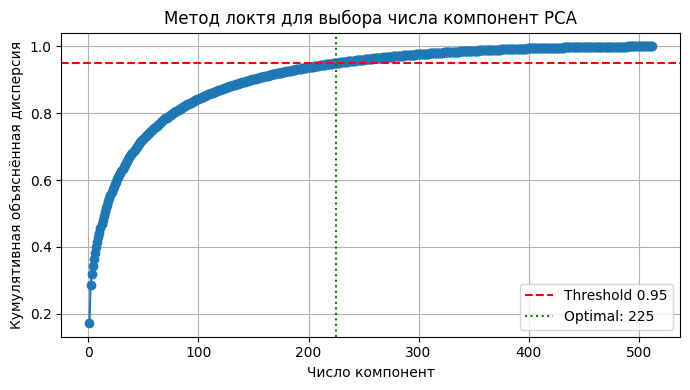

In [307]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Пусть image_embeds — это [N, D] эмбеддинги твоих изображений в том же порядке, что и image_df
# Например: image_embeds = model.encode_image(...)

opt_n  = plot_pca_elbow(image_embeds)

In [308]:

n_components = max(2, opt_n)
pca = PCA(n_components=n_components)
image_embeds_pca = pca.fit_transform(image_embeds)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
image_embeds_2d = tsne.fit_transform(image_embeds_pca)

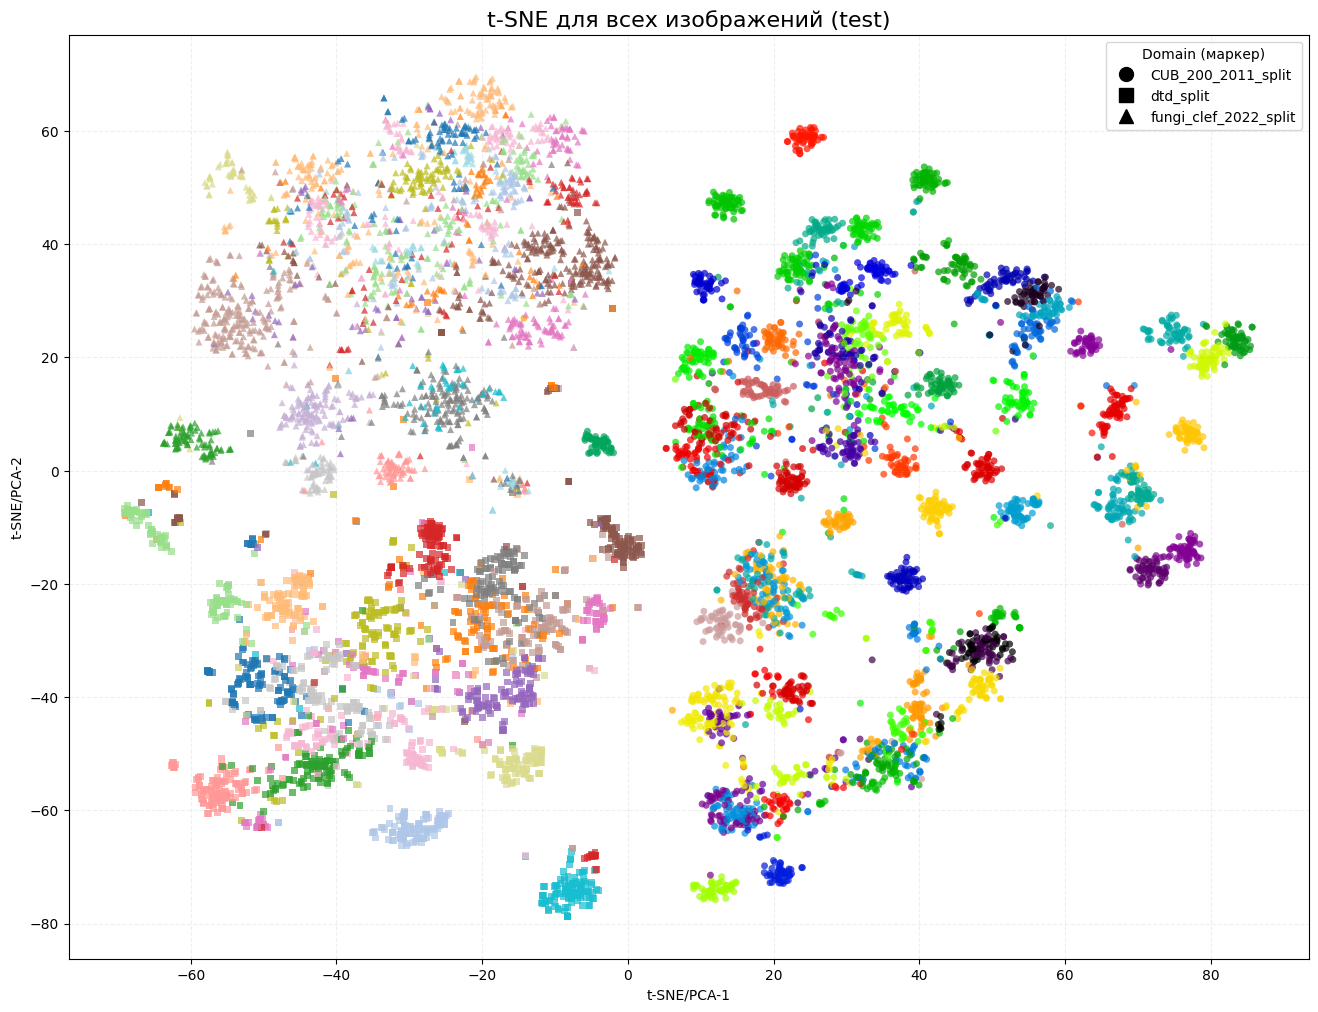

In [310]:
visualise_embeddings(image_embeds_2d,image_df, split)

In [ ]:
blob:vscode-webview://0f24ksmoubs1r254dq3bhcgqo6b3t71ap8dcfdccc3h0qiluutrh/a1da67e6-2b39-49e7-8aea-699fded2edfd

In [303]:
import matplotlib.pyplot as plt
import numpy as np




def visualise_embeddings(image_embeds_2d, image_df, split):

    unique_domains = sorted(image_df['domain'].unique())
    marker_list = ['o', 's', '^', 'D', 'P', '*', 'v', '<', '>', 'X']
    domain_to_marker = {d: marker_list[i % len(marker_list)] for i, d in enumerate(unique_domains)}

    plt.figure(figsize=(16, 12))
    legend_handles = []

    for domain_idx, domain in enumerate(unique_domains):
        domain_mask = image_df['domain'] == domain
        domain_idxs = np.where(domain_mask)[0]
        domain_marker = marker_list[domain_idx % len(marker_list)]


        domain_classes = image_df.loc[domain_mask, 'class_name'].unique()
        n_dom_classes = len(domain_classes)
        if n_dom_classes <= 20:
            domain_cmap = plt.cm.tab20
        elif n_dom_classes <= 256:
            domain_cmap = plt.cm.nipy_spectral
        else:
            base_colors = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
            domain_cmap = lambda x: base_colors[x % 256]
        class_to_color = {c: domain_cmap(i / n_dom_classes) if callable(domain_cmap) else domain_cmap(i) 
                        for i, c in enumerate(domain_classes)}
        

        colors = [class_to_color[c] for c in image_df.loc[domain_mask, 'class_name']]
        
        plt.scatter(
            image_embeds_2d[domain_idxs, 0],
            image_embeds_2d[domain_idxs, 1],
            c=colors,
            marker=domain_marker,
            label=domain,
            s=25,
            alpha=0.7,
            edgecolor='none'
        )

        import matplotlib.lines as mlines
        legend_handles.append(
            mlines.Line2D([], [], color='black', marker=domain_marker, linestyle='None', markersize=10, label=domain)
        )

    plt.title(f"t-SNE для всех изображений ({split})", fontsize=16)
    plt.xlabel("t-SNE/PCA-1")
    plt.ylabel("t-SNE/PCA-2")
    plt.grid(True, linestyle='--', alpha=0.2)
    plt.legend(handles=legend_handles, title="Domain (маркер)", loc='best')
    plt.show()

visualise_embeddings(image_embeds_2d,image_df, 'test')

IndexError: index 8777 is out of bounds for axis 0 with size 8773

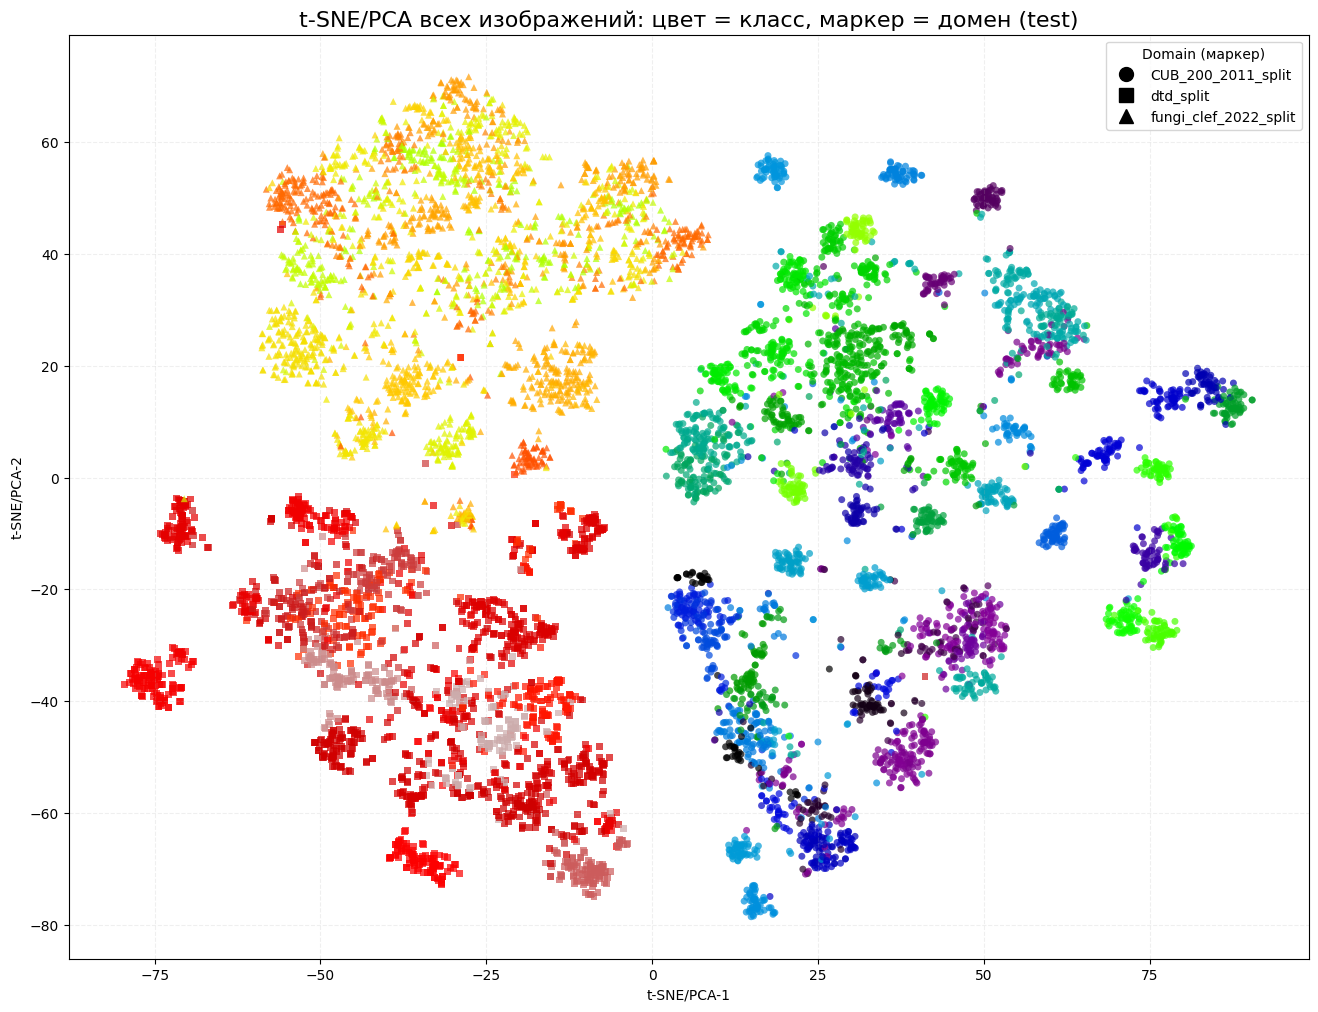

In [73]:
plt.figure(figsize=(16, 12))
for marker in set(markers):
    idxs = [i for i, m in enumerate(markers) if m == marker]
    plt.scatter(
        image_embeds_2d[idxs, 0],
        image_embeds_2d[idxs, 1],
        c=np.array(colors)[idxs],
        marker=marker,
        label=f'Domain {marker}',
        s=25,
        alpha=0.7,
        edgecolor='none'
    )

plt.title(f"t-SNE/PCA всех изображений:({split})", fontsize=16)
plt.xlabel("t-SNE/PCA-1")
plt.ylabel("t-SNE/PCA-2")
plt.grid(True, linestyle='--', alpha=0.2)

# Легенда по маркерам/доменам (краткая)
import matplotlib.lines as mlines
handles = [mlines.Line2D([], [], color='black', marker=domain_to_marker[d], linestyle='None', markersize=10, label=d)
           for d in unique_domains]
plt.legend(handles=handles, title="Domain (маркер)", loc='best')

plt.show()